## Makemore with MLP (Part 2)

This section will study the gradients of the network in more detail to understand how they can be optimised, before proceeding to different network architectures like RNNs, where it is more difficult to optimise.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos, stoi, vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} 27


In [5]:
# training split, validation split, test split
# 80%, 10%, 10%

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

print(n1, n2, n2 - n1)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 28829 3203
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # make hidden layer slightly smaller
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # no. of parameters

for p in parameters:
    p.requires_grad = True

11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8547
  20000/ 200000: 2.5158
  30000/ 200000: 2.8251
  40000/ 200000: 2.0468
  50000/ 200000: 2.5537
  60000/ 200000: 2.3718
  70000/ 200000: 2.1337
  80000/ 200000: 2.2612
  90000/ 200000: 2.3405
 100000/ 200000: 2.0309
 110000/ 200000: 2.4856
 120000/ 200000: 1.9046
 130000/ 200000: 2.4561
 140000/ 200000: 2.2440
 150000/ 200000: 2.1515
 160000/ 200000: 2.0846
 170000/ 200000: 1.8103
 180000/ 200000: 2.0295
 190000/ 200000: 1.8398
2.4244534969329834


In [12]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N,  block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.131074905395508


In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialise with all "..."
    
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out[:-1]))

mora
kayah
seen
nihah
marethrus
jarlee
azeredielin
shi
jenleigh
estanar
kayzion
kamin
shubergahiriel
kin
renel
panterianu
zen
dariyah
fael
yuma


### Some problems

Notice that in the first iteration, upon initialisation the loss of our network is very high, ` 0/ 200000: 27.8817`. The initialisation is all messed up.

In training neural nets, you usually have a rough idea of what loss to expect at initialisation (depends on loss function and problem setup).

It wouldn't be wrong to believe that at initialisation, the distribution of next characters is uniform (equal probability of each character).

This means the probabiity of each character should be roughly 1 / 27.

In [20]:
-torch.tensor(1 / 27.0).log() # this should be the initialisation loss, much lower than 27.8817

tensor(3.2958)

Higher loss = more confidently **wrong**.

In [36]:
# 4D example of the issue
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0]) # play around with the values here, we get lower loss when the third element is higher tham the others
# logits = torch.randn(4) * 10

probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # say we are predicting the third char
probs, loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

**Dissecting the variables after the first iteration**

In [49]:
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # make hidden layer slightly smaller
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # no. of parameters

for p in parameters:
    p.requires_grad = True

11897


In [50]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


The logits have quite extreme values, which is creating the incorrect answers. 

They shoud be much, much closer to 0. How?

Here's how they were calculated: `logits = h @ W2 + b2`

Let's try scaling down W2 and set b2 to 0. (refer to cell above)

We will use a value of 0.01, and we see that the loss is roughly what we want with a little bit of entropy.

Now, let's run our training and see how it goes.

**Can we set `W2` to zero?**

No. It would be fine but things may *go wrong*.

In [51]:
logits[0]

tensor([-2.6747,  2.1230, -0.6957, -0.1797,  0.2563,  2.4494, -1.8891, -2.4445,
        -1.0200,  2.9168, -2.3774, -0.5807,  3.0092,  1.9834,  3.8758,  1.2065,
        -0.8338, -3.8638,  1.6995,  1.6316,  0.5563, -2.8112,  0.3735, -2.5029,
        -2.7555,  2.9825, -0.0861], grad_fn=<SelectBackward0>)

The loss plot is no longer that hockey-stick shaped plot as we are kind of *taking away the easy work* of the loss function

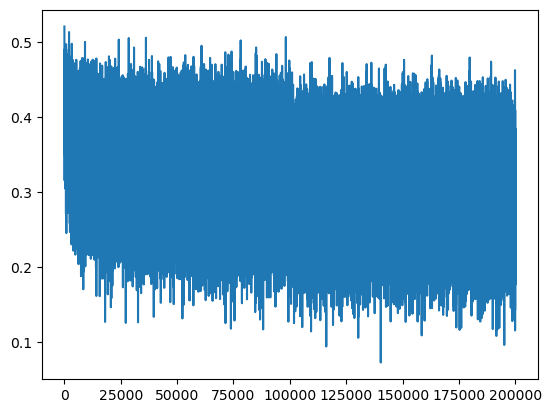

In [52]:
plt.plot(lossi)

Result is better than before! Our neural network is spending more time optimising than squashing down the weights which were initially way too high.

In [53]:
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.102678060531616


**Another problem (Saturated gradients)**

The logits are now okay, but the value of `h` is not. Observe that most of the elements in it are 1 and -1.

Recall that the $tanh$ function is a *squashing* function, i.e. it compresses a value down to -1 and 1.

Let's plot a histogram to see the distribution of values in `h`.

In [44]:
h

tensor([[ 0.5503, -0.1064, -0.6658,  ..., -0.3477, -0.9756,  0.8880],
        [-0.9081, -0.1924, -0.1833,  ...,  0.0494,  0.4942,  0.4397],
        [ 0.8016,  0.1173,  0.8237,  ...,  0.2890,  0.6476,  0.8827],
        ...,
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849],
        [-0.9362,  0.0930, -0.2810,  ..., -0.1260,  0.7874,  0.9102],
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849]],
       grad_fn=<TanhBackward0>)

`h` has 32 examples and 200 activations in each example

In [45]:
h.shape

torch.Size([32, 200])

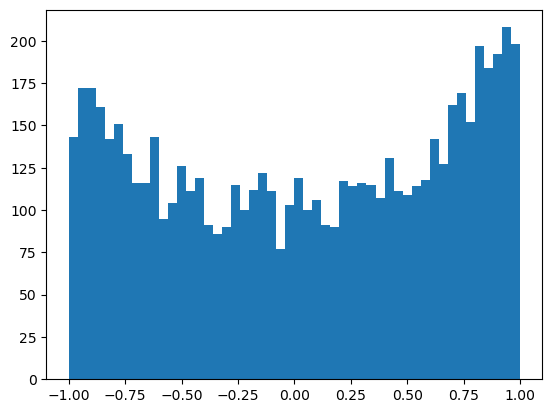

In [46]:
plt.hist(h.view(-1).tolist(), 50); # stretch it out into a vector and plot the distribution

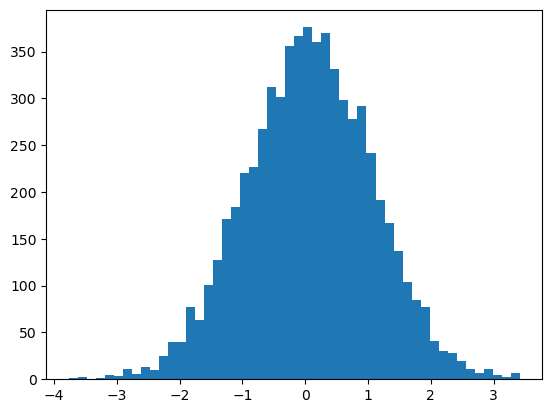

In [47]:
plt.hist(hpreact.view(-1).tolist(), 50);

Notice that the preactivation values are very broad, they take on a wide range of values from -20 to 20.


**Why don't we want the gradient values in `h` to be -1, 1?**

Recall in `micrograd` that the `_backward()` method of $tanh$ is as follows:

```
def _backward():
  self.grad += (1 - t**2) * out.grad
```

where `t` is the computed value of $tanh$.

Plug in $t = -1, 1$ into the equation above and you get **zero**! The gradients are not increasing at all!

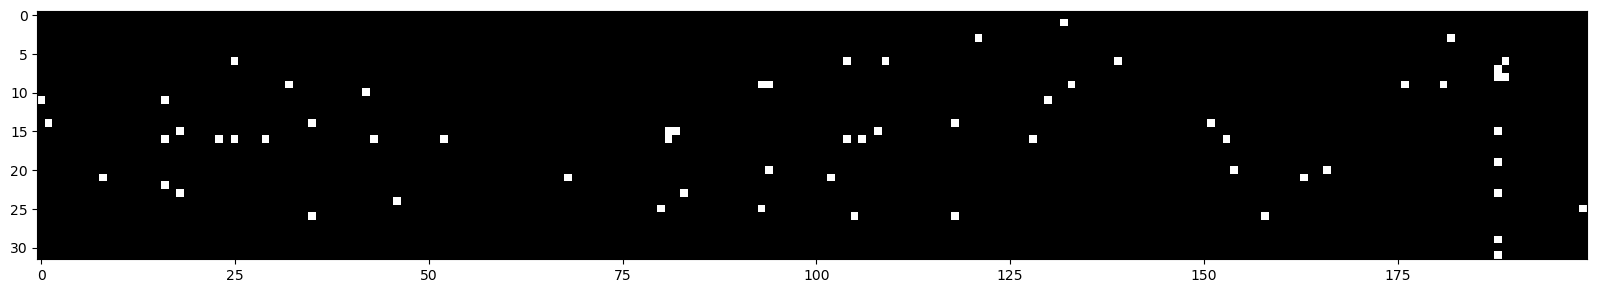

In [48]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # we see how often are values in h at the flat gradient of tanh

White cells indicate true, i.e. $> 0.99$

Note that we are in trouble if there is an entire column which is white. This is what is called a *dead neuron*. No single example ever activates this neuron, it never learns.

The same phenomenon happens for other activation functions like sigmoid, which squishes values in the range of $0$ and $1$ instead, as well as Recitifed Linear Unit (ReLU) which has a zero gradient if the value pre-activation is negative.

**How do we fix this?**

After multiplying with `W1` and adding to `b1`, `hpreact` is too far away from 0. (similar to what we want with logits)

### How do we choose those scale values to scale down our weights and biases?

We're talking about all those $0.2$'s $0.01$'s, etc.

Let's explore. Here we have `x` and `w` which are drawn from a Gaussian distribution.
`y` is the preactivations of the neurons.

Observe what happens to the mean and STD when we multiply `x` and `w`. The mean stays the same, but the standard deviation increases by a lot.

We want neurons in the neural network to roughly have Gaussian values all throughout.

<br>

**How do we scale `w` to preserve the Gaussian distribution?** 

*Gaussian distribution has mean 0 and STD 1*

Using math, we discover that you scale down by $\sqrt{n_i}$, where $n_i$ is the fan in of the layer. In this case $n_i$ is $\sqrt{10}$ (w has 10 inputs)

More here (Kaiming et al.): https://arxiv.org/pdf/1502.01852.pdf

tensor(0.0019) tensor(0.9969)
tensor(0.0001) tensor(1.0061)


(array([2.03533157e-05, 0.00000000e+00, 0.00000000e+00, 2.03533157e-05,
        2.03533157e-05, 1.42473210e-04, 2.84946420e-04, 2.84946420e-04,
        2.44239789e-04, 6.51306103e-04, 1.44508542e-03, 1.99462494e-03,
        4.35560956e-03, 6.51306103e-03, 1.07872573e-02, 1.68932520e-02,
        2.94105412e-02, 4.68533328e-02, 6.50084904e-02, 1.01685165e-01,
        1.46218220e-01, 2.01009346e-01, 2.66689496e-01, 3.35015577e-01,
        3.96625063e-01, 4.32080539e-01, 4.27053270e-01, 3.89196103e-01,
        3.28929935e-01, 2.61031274e-01, 1.93539679e-01, 1.37730887e-01,
        9.58844703e-02, 6.31970453e-02, 4.23756033e-02, 2.59097709e-02,
        1.73003184e-02, 9.83065149e-03, 6.10599471e-03, 3.23617720e-03,
        2.17780478e-03, 1.03801910e-03, 8.95545891e-04, 4.47772946e-04,
        3.05299736e-04, 1.22119894e-04, 6.10599471e-05, 0.00000000e+00,
        0.00000000e+00, 4.07066314e-05]),
 array([-6.37018061, -6.12452039, -5.87886017, -5.63319995, -5.38753973,
        -5.14187951, 

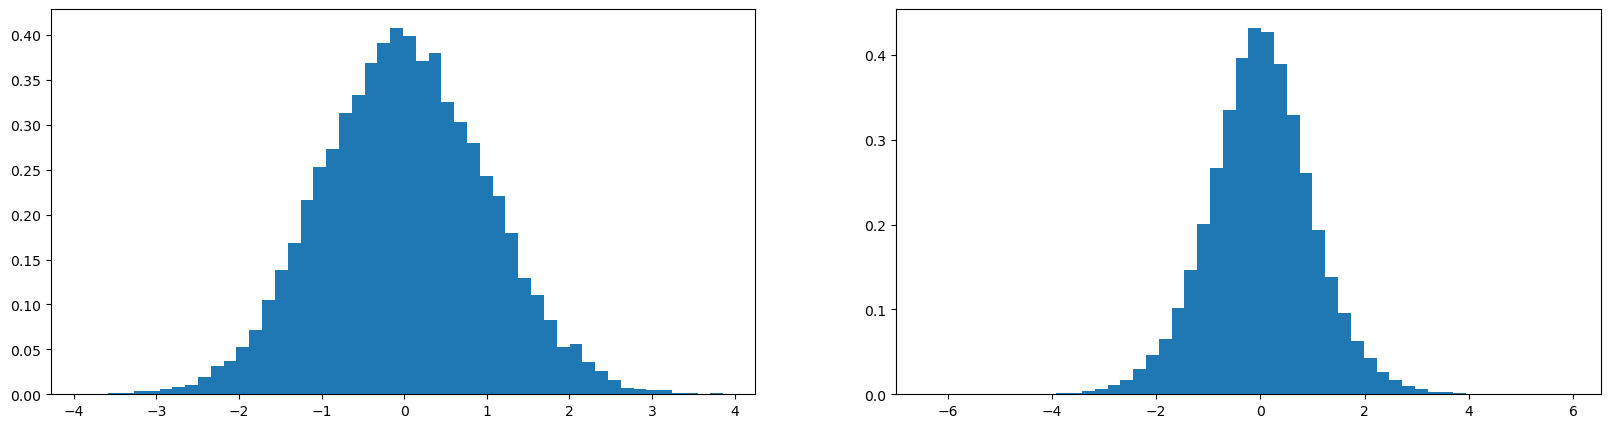

In [56]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [59]:
(torch.randn(100000) * 0.2).std() # notice SD becomes whatever we multiply by

tensor(0.2005)

In [63]:
tanh_gain = 5 / 3
fan_in = 30

target_std = tanh_gain / (fan_in**0.5)
target_std

0.3042903097250923

**Why is $tanh$ gain $\frac{5}{3}$?**

Intuitively and simply put, it is because the $tanh$ squishes the values between -1 and 1, hence a value greater than 1 is needed to boost them back up.

In [64]:
# Initialising weights with Kaiming value

n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer of the MLP

tanh_gain = 5 / 3 # suggested gain
fan_in = n_embd * block_size
target_std = tanh_gain / (fan_in**0.5)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * target_std
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # no. of parameters

for p in parameters:
    p.requires_grad = True

11897


In [65]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [66]:
split_loss('train')
split_loss('val')

train 2.0376644134521484
val 2.106989860534668


### Batch Normalisation

You used to need to be very careful (7 years back) when initialising the weights of a deep neural network. Innovations like batch normalisation reduce the need for doing so!

https://arxiv.org/pdf/1502.03167.pdf

In the training code above, recall that we don't want `hpreact` to be too big or too small. or else $tanh$ gradient just saturates. We want the values to be *roughy Gaussian*. 

Idea: $tanh$ is most "active" when inputs are in the range of Gaussian values.

What batch normalisation then suggests is to **just normalise them to be Gaussian**!

In [68]:
hpreact.shape

torch.Size([32, 200])

In [70]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [71]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [7]:
def normalise(hpreact, mean, std):
    return (hpreact - mean) / std 

In [6]:
# scale and shift

n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer of the MLP

tanh_gain = 5 / 3 # suggested gain
fan_in = n_embd * block_size
target_std = tanh_gain / (fan_in**0.5)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * target_std
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# batch normalisation gain
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# running average
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

print(sum(p.nelement() for p in parameters)) # no. of parameters

for p in parameters:
    p.requires_grad = True

12297


`bn_gain` and `bn_bias` are initialised to these values so that you get a Gaussian at the start (refer to cell below for explanation).

During optimisation we will be able to backpropagate to them, so they will get updated as the training progresses.

In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    hpreact = embcat @ W1 # + b1 batch norm has its own bias, so we can remove this bias here as its redundant
    bn_mean_i = hpreact.mean(0, keepdim=True)
    bn_std_i = hpreact.std(0, keepdim=True)
    hpreact = bn_gain * normalise(hpreact, bn_mean_i, bn_std_i) + bn_bias
    
    # we don't need gradient optimisation for these values
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


You actually won't get a very good result with this because we want `hpreact` to be roughly Gaussian only at initialisation. In other words, we don't want to force them to be Gaussian always, we allow some sort of *variation* in the behaviors of the neurons.

The paper further suggests a method called "scale and shift", where you scale the normalise inputs by some value and then add a bias term.

Note that we aren't really expecting much of an improvment in the loss using batch normalisation. And this is because our neural net is very small (with just a single hidden layer)!

When you have a much deeper neural net, it will become very difficult to tune activations throughout the network to be roughly Gaussian. It becomes intractable.

Compared to that, it becomes easier then to just *sprinkle* batch normalisation layers throughout.

**Notice something unnatural and weird in batch normalisation**

What we used to have before this was we feed in an example, we calculate `hpreact`, `h` and `logits`, so you'd say its pretty *deterministic* as `logits` are a function of the example.

When we use batch normalisation, notice that due to the usage of minibatches, the normalisation layer parameters, `bn_gain` and `bn_bias` are influenced by (coupled to) the random batches that *come for a ride* each round of training.

So now, `logits` are no longer a function of just the example, but rather a function of all these values! This leads to some jitter in the output.

Is this jitter bad? Not necessarily. It turns out such jitter may be good for neural network training as a regulariser!

It is some sort of data augmentation, reduces overfitting! Batch normalisation is a regularisation technique! :O

It is not really favorable in practical use, and so people have actually tried out other means of normalisaion like layer normalisation, instance, group, etc.

**In a real setting**

When you deploy the model, you usually feed it a single input and it makes its prediction. But the neural network expects batches.

The paper suggests to set the batch normalisation mean a single time over the entire training set.

Another technique (to avoid all the trouble below) is to calculate a running average as we train (refer to above cell).

In [10]:
# calibrate the batch norm at end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # measure mean /std over entire training set
    bn_mean = hpreact.mean(0, keepdim=True)
    bn_std = hpreact.std(0, keepdim=True)

In [11]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N,  block_size * n_embd)
    
    hpreact = embcat @ W1 + b1
    hpreact = bn_gain * normalise(hpreact, bn_mean_running, bn_std_running) + bn_bias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.066591739654541
val 2.1050572395324707


### A Real Example: ResNet

The GitHub code for a residuel neural network has the same motif as what we have been doing for our character model -- we always have a weight layer, batch normalisation layer, non-linearity activation.

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

Example from PyTorch code:
```
out = self.conv1(x)
out = self.bn1(out)
out = self.relu(out)
```

Corresponds to our:
```
hpreact = embcat @ W1
hpreact = normalise(hpreact)
h = torch.tanh(preact)
```

### PyTorch implementations of Linear Model

Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

Observe how they initialise the weights and biases, its quite similar to what we learnt that is to scale by some gain ($\frac{5}{3}$ for $tanh$) and also by $\sqrt{in\_features}$. 

However, they use a uniform distribution from $-\sqrt{k}$ to $\sqrt{k}$ instead.

### Pytorch implementations of BatchNorm

https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

There's a parameter `momentum` that the method takes and has a default value of `0.1`. What is it?

It is the "weight" that you use to update the running mean/std each round, in this case 0.001.

`bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i`

**How do you choose this value?**

It depends on your batch size. For larger batches, there is less variance and the mean values across batches are roughly similar. Hence, a higher momentum can be used and the running mean can converge to the actual mean.

If you have a small batch, like in our case its 32, the variance is high, and the means across different batcehs differ alot. Using a high momentum will prevent it from converging, and it kind of *thrashes* around a lot.



## PyTorch-ifying the code

In [58]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out +=  self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # this is just to maintain statistics for later

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [59]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


Below is a histogram of the forward pass activations. Play around with the linear gain on top to see how the histograms below change!

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

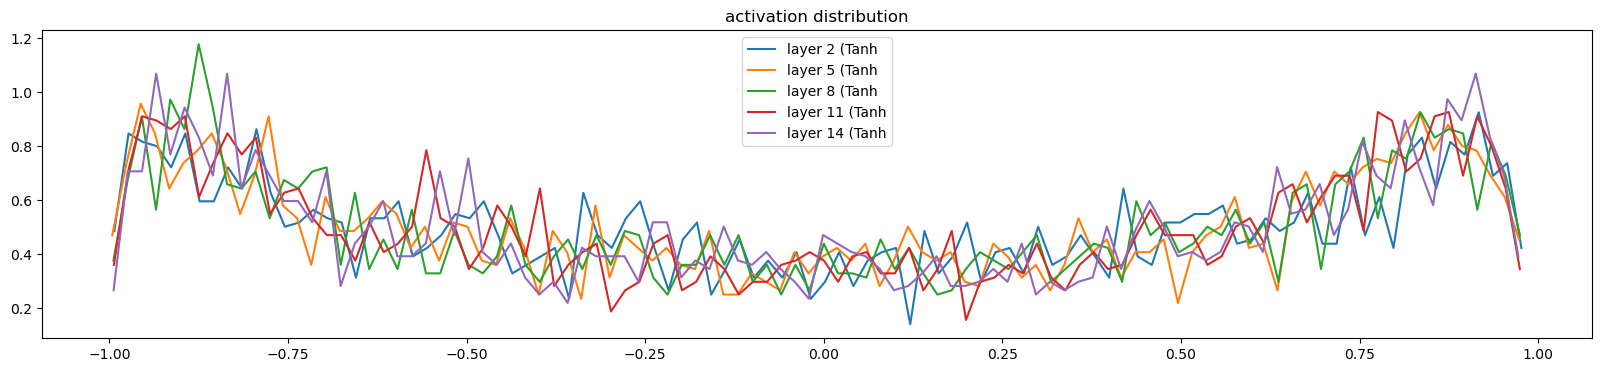

In [60]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

The standard deviation stabilises at a value of around 0.65, and saturation would be roughly 5%. This is because the gain is set to $\frac{5}{3}$.

**What if you don't use a gain?**

`layer.weight *= 1`

We will see that the standard deviation is shrinking and saturation goes to 0%. When you have linear + $tanh$ stacked like we have, a gain of 1 will not *fight against* the *squashing* of the $tanh$. Recall the gain is there to boost the standard deviation of the weights back to some value.

Below is the gradient plotted.

layer 2 (      Tanh): mean -0.000000, std 3.682956e-03
layer 5 (      Tanh): mean +0.000000, std 3.262610e-03
layer 8 (      Tanh): mean +0.000000, std 2.973731e-03
layer 11 (      Tanh): mean +0.000000, std 2.741111e-03
layer 14 (      Tanh): mean -0.000000, std 2.584294e-03


Text(0.5, 1.0, 'gradient distribution')

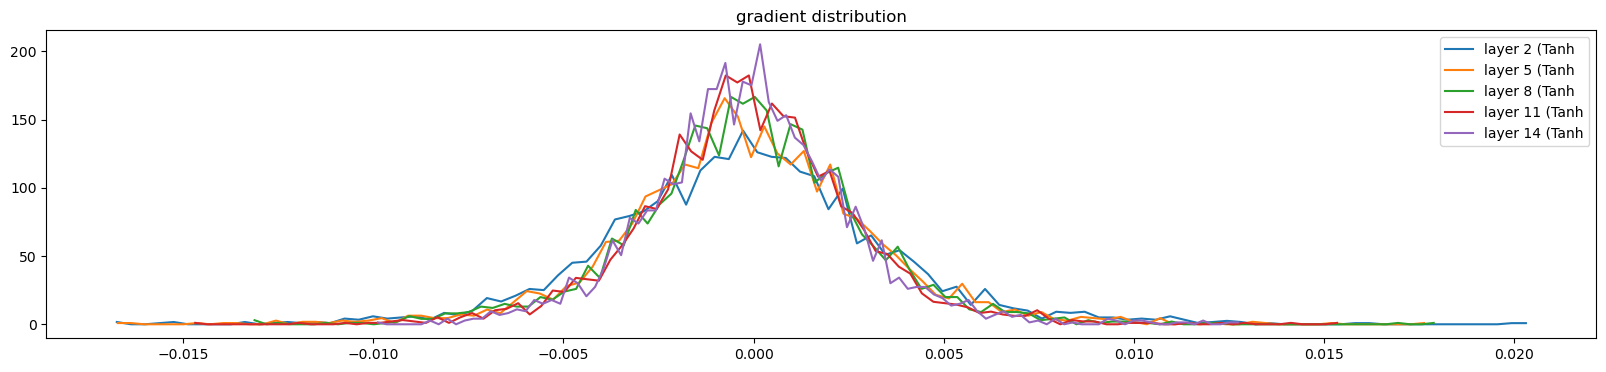

In [61]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

#### What happens when we remove the $tanh$?

Not sure what's wrong with my code but there are errors :')

Based on the video, Karpathy showed that with a gain of $\frac{5}{3}$ the gradients and activations decreased as the layers increased, which is not a good place to be, cause you only have Linear layers at this point.

So, to fix this, change the gain to 1.

#### Why do we need $tanh$?

Without the $tanh$ you just have a huge linear *sandwich*, and when you plot the output against input, you will get a linear function. Everything is just a linear transformation.

The graph looks a bit weird...

weight   (27, 10) | mean +0.000000 | std 1.019887e-02 | grad:data ratio 1.018848e-02
weight  (30, 100) | mean +0.000092 | std 8.238432e-03 | grad:data ratio 2.635840e-02
weight (100, 100) | mean +0.000031 | std 7.318114e-03 | grad:data ratio 4.377145e-02
weight (100, 100) | mean -0.000019 | std 6.662026e-03 | grad:data ratio 3.949897e-02
weight (100, 100) | mean -0.000019 | std 5.821516e-03 | grad:data ratio 3.468161e-02
weight (100, 100) | mean +0.000053 | std 5.445297e-03 | grad:data ratio 3.243368e-02
weight  (100, 27) | mean -0.000165 | std 1.046845e-02 | grad:data ratio 6.281264e-02


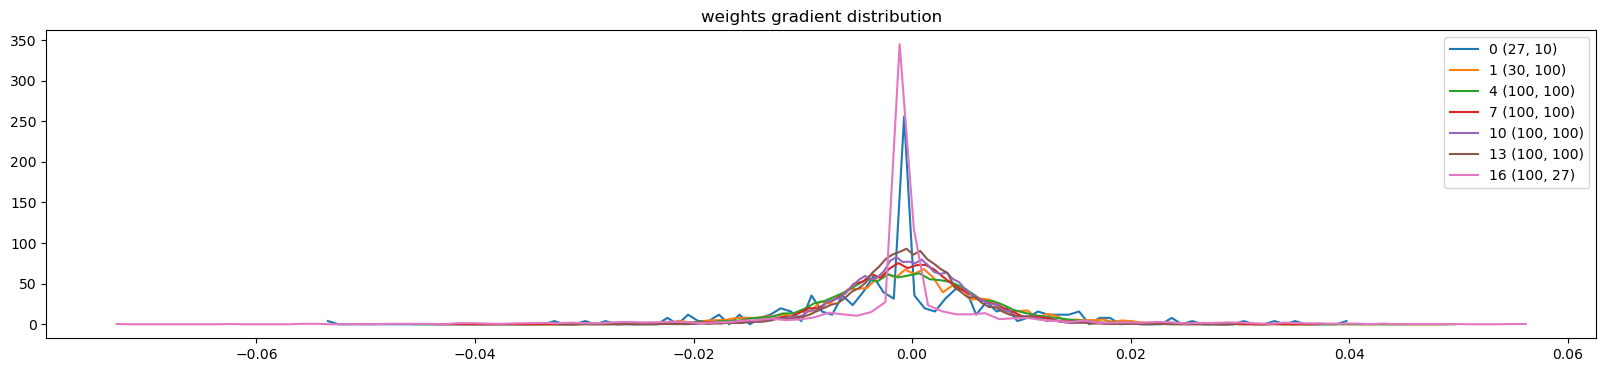

In [62]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Observe the gradient-to-data ratio in the last column. We are in trouble if this ratio is too big.

The last layer are quite spread out, and you can see this in the statistics printed out above, i.e. the std of the last layer is around 10x time higher than that of the other layers

Another important metric is the update-to-data ratio, because that is the amount we will change the data in the tensors.

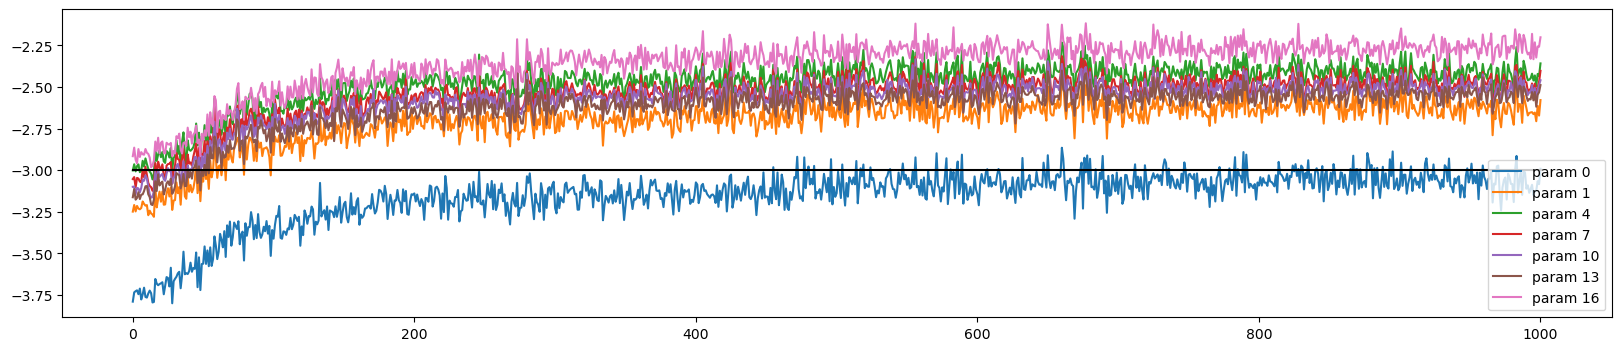

In [63]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

The black line is a rough indicator to how much your update should be. Play around with the learning rate on top to see how this graph changes. This is a good indicator to tell you how to change your learning rate.

The pink line has a high value as we shrunk its weights above.